Fig8, current clamp, slope measurements

In [1]:
from neuron import h
import numpy as np
import os.path
import sys
sys.path.append('../../libs/')

In [ ]:
# compile neuron channels
!cd ../../data/morphology && nrnivmodl && cd -

In [2]:
# load model
# works only on linux
model = '../../data/morphology/soma_axon.hoc'
dllpath = '../../data/morphology/x86_64/.libs/libnrnmech.so'
h.nrn_load_dll(dllpath)
h.load_file(model)
h.init_cell()

0.0

In [3]:
# parameters
keep_soma_Na = True
soma_area = 3000 # um
thres_range = [5, 100] # values of dV/dt

soma_size = np.sqrt(soma_area/np.pi) # d and l
if soma_area <20:
    stim_amp = 10e-05*soma_area
else:
    stim_amp = 2.069e-05*soma_area

# simulation
h.tstart = 0.
h.tstop = 20.
h.dt = 0.001
rm = 30000.
st_dur1 = 2.
st_dur2 = 3.
v_init = -70

# morphology 
h.soma.L = soma_size
h.soma.diam = soma_size
h.soma.nseg = 6
h.soma.g_pas = 1./rm
h.soma.cm = 0.75

h.axon.L = 50.
h.axon.diam =1.
h.axon.nseg = 10
h.axon.g_pas = 1./rm
h.axon.cm = 0.75 * 0.75

# general
h.rm = rm
h.v_init = v_init
h.ra = 150 
h.c_m = 0.75
h.xn = 1 

# potassium
h.Ek = -80. # mV # Fig2: = 80; Fig4b:
h.gk = 1600.
h.gkm = 0.3
h.soma.gbar_kv = 1600/5.
h.axon.gbar_kv = 1600.

# sodium
h.Ena = 60.
h.gna = 8000.
h.gkm_soma = 0.3
if keep_soma_Na:
    h.soma.gbar_na = 0.1*8000
else:
    h.soma.gbar_na = 0.
h.axon.gbar_na = 8000.
            
# calcium (set no calcium in the model)
h.gca = 0.
h.gkca = 0.
h.gca_soma = 0.
h.gkca_soma = 0.

In [4]:
# create I-clamp stimulation
st = h.IClamp(0.5, sec = h.soma)
st.dur = 7 # ms
st.delay = 1
st.amp = stim_amp

In [5]:
# record in the soma and in the axon end
vec_soma = h.Vector()
vec_soma.record(h.soma(0.5)._ref_v, sec=h.soma)
vec_axon_end = h.Vector()
vec_axon_end.record(h.axon(0.99)._ref_v, sec=h.axon)
h.run()

0.0

In [6]:
# calculate slopes
v_soma = np.array(vec_soma)
v_axon = np.array(vec_axon_end)
deriv_soma = np.diff(v_soma)/h.dt
deriv_axon = np.diff(v_axon)/h.dt

# use only rising slope
max_dv_soma = np.argmax(deriv_soma)
dv_soma4slope = deriv_soma[:max_dv_soma]
v_soma4slope = v_soma[:max_dv_soma]

max_dv_axon = np.argmax(deriv_axon)
dv_axon4slope = deriv_axon[:max_dv_axon]
v_axon4slope = v_axon[:max_dv_axon]

# check slopes in mv range > -60 mV
rg_idx = np.where(v_soma4slope > -60)[0][0]
v_soma4slope = v_soma4slope[rg_idx:]
dv_soma4slope = dv_soma4slope[rg_idx:]

rg_idx_a = np.where(v_axon4slope > -60)[0][0]
v_axon4slope = v_axon4slope[rg_idx_a:]
dv_axon4slope = dv_axon4slope[rg_idx_a:]

# soma
slopes_soma = [(dv_soma4slope[i+1]-dv_soma4slope[i])/(v_soma4slope[i+1]-v_soma4slope[i]) for i in range(len(v_soma4slope)-1)]
max_soma = np.max(slopes_soma)
max_soma_idx = np.argmax(slopes_soma)+rg_idx

# axon
slopes_axon = [(dv_axon4slope[i+1]-dv_axon4slope[i])/(v_axon4slope[i+1]-v_axon4slope[i]) for i in range(len(v_axon4slope)-1)]
max_axon = np.max(slopes_axon)
max_axon_idx = np.argmax(slopes_axon)+rg_idx_a

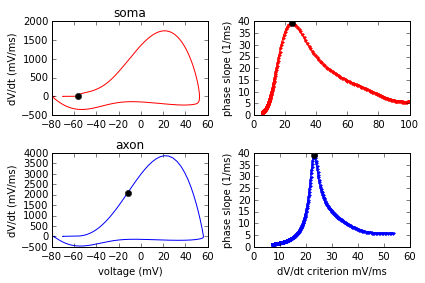

In [7]:
# plot the figure
import matplotlib.pylab as plt
%matplotlib inline

plt.subplot(2,2,1)
time = np.arange(len(v_soma))*h.dt
plt.plot(v_soma[:-1], deriv_soma, 'r', label = 'soma')
plt.plot(v_soma[:-1][max_soma_idx], deriv_soma[max_soma_idx], 'ko')
plt.title('soma')
plt.ylabel('dV/dt (mV/ms)')

plt.subplot(2,2,2)
thres_soma_min = np.where(dv_soma4slope > thres_range[0])[0][0]
thres_soma_max = np.where(dv_soma4slope < thres_range[1])[0][-1]
plt.plot(dv_soma4slope[thres_soma_min:thres_soma_max], slopes_soma[thres_soma_min:thres_soma_max], 'r')
plt.plot(dv_soma4slope[thres_soma_min:thres_soma_max], slopes_soma[thres_soma_min:thres_soma_max], 'r.')
plt.plot(dv_soma4slope[max_soma_idx-rg_idx], slopes_soma[max_soma_idx-rg_idx], 'ko')
plt.ylabel('phase slope (1/ms)')

plt.subplot(2,2,3)
plt.plot(v_axon[:-1], deriv_axon, 'b', label = 'axon')
plt.plot(v_axon[:-1][max_axon_idx], deriv_axon[max_axon_idx], 'ko')
plt.xlabel('voltage (mV)')
plt.ylabel('dV/dt (mV/ms)')
plt.title('axon')

plt.subplot(2,2,4)
thres_axon_min = np.where(dv_axon4slope > thres_range[0])[0][0]
thres_axon_max = np.where(dv_axon4slope < thres_range[1])[0][-1]
plt.plot(dv_axon4slope[thres_soma_min:thres_soma_max], slopes_soma[thres_soma_min:thres_soma_max], 'b')
plt.plot(dv_axon4slope[thres_soma_min:thres_soma_max], slopes_soma[thres_soma_min:thres_soma_max], 'b.')
plt.plot(dv_axon4slope[max_soma_idx-rg_idx], slopes_soma[max_soma_idx-rg_idx], 'ko')
plt.xlabel('dV/dt criterion mV/ms')
plt.ylabel('phase slope (1/ms)')
plt.tight_layout()